In [ ]:
import sys,os

sys.path.append('/home/arash/ProjectVR/')
import statistics
import importlib
import deepsurv
import json
import time
import numpy as np
import pandas as pd
import pickle
import theano.tensor
import lasagne
import optunity
import scipy
import scipy.stats
import scipy.integrate as integrate
#import logging
#from logging import handlers
#from sklearn.model_selection import train_test_split
from scipy.stats import lognorm, expon, weibull_min,gamma,norm
importlib.reload(deepsurv)

from deepsurv import deep_surv, utils

#from deepsurv.deepsurv_logger import DeepSurvLogger, TensorboardLogger

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Load trained network and data

In [ ]:
#deepsurv formatted data    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtest', 'rb') as f:
    xtest=pickle.load(f)

with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtrain', 'rb') as f:
    xtrain=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/ytrain', 'rb') as f:
    ytrain=pickle.load(f)  
    
#dataframe data with wait times and col names    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctest', 'rb') as f:   
    NCtest=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctrain', 'rb') as f:   
    NCtrain=pickle.load(f) 
    
network=deep_surv.load_model_from_json(model_fp = '/home/arash/ProjectVR/models/Deepwait100epochsTuned',
                     weights_fp = '/home/arash/ProjectVR/models/deepwait_weights_100_epochs.npz')

### Predicting event times
To predict the time of event for instances, having an estimation of partial hazard is not sufficient. First, baseline hazard is required to estimate hazard function, which will be a function of time and covariates. The next step would be to calculate survival function. Finally, expected wait time can be calculated by:
\begin{equation}
    E(t)=\int_{t=0}^\infty S(t)dt
\end{equation}
Baseline hazard is interpreted as hazard function regardless of the values of the covariates (or when they are all 0). Different methods have been suggested in the literature for an estimation of baseline hazard. 
deepwait predicts wait time for autonmous vehicle, so the data used will be solely those ones that the car can observe, not sociodemographic etc, and the baseline hazards are calculated based on training data, as the car will not know about other pedestrians at risk etc.

In [3]:
def cumhazard (x):          #x: covariates of the instance we are looking into
    parthazard = network.hazard(x) 
    hazard = parthazard * CumBase
    return hazard[0]

risks = network.predict_risk(xtrain[:,0:network.hyperparams['n_in']]) #calculate logpartial hazard 
## Modify risks to have a zero mean
modifiedrisks = risks - risks.mean()
parthazards = np.exp(modifiedrisks)    #calculate partial hazard 

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### Baseline Hazard: Breslow
For CPH, the method used in python package is extracted from Breslow [1972]. In their method, "the underlying survival distribution is
parameterized as a continuous one, having constant hazards $\lambda_i$ between each
pair $t_{i-1}$ to $t_i$ of distinct relapse times. If all withdrawals, or censored observations, which
occur in the interval $(t_i, t_{i+1})$ are adjusted to have occurred at $t_i$ , the ML estimator of
$\lambda$ in terms of $\beta$ coefficients at time $t_i$ by:
\begin{equation}
\label{eq:9}
    \lambda_i=\frac{m_i}{\displaystyle \sum_{j: T_j>T_i } e^{\beta*Z_j}}
\end{equation}
in which $m_i$ is the number of events at time $t_i$, Equation above is provided for CPH. In deepwait, we replace the partial hazards part with the exp of the output of our network 

In [4]:
NCtrain['Partial Hazards'] = parthazards

#eventtimes = NCtrain.sort_values(by=['Wait Time (s)'])['Wait Time (s)'].unique()     #sorted event times

discreteTimes = np.arange(0.0, max(NCtrain['Wait Time (s)']),0.1)   #define discrete times with 0.1 timesteps

#m_i in the baseline hazard formula, sorted by time
eventnum=[]
for t in discreteTimes:
    eventnum.append(NCtrain[(t<=NCtrain['Wait Time (s)']) &
                            (NCtrain['Wait Time (s)']<(t+0.1))].shape[0])

In [5]:
#eventnum = NCtrain['Wait Time (s)'].value_counts().sort_index() 
basehazard=[]
for i in range(len(discreteTimes)):
    basehazard.append(
        eventnum[i] / ((sum(NCtrain['Partial Hazards'][NCtrain['Wait Time (s)'] >= discreteTimes[i]])))
    )

In [6]:
# creating a df of hazards
eventsDF = pd.DataFrame({'Times': discreteTimes, 'Counts': eventnum, 'Base Hazard': basehazard })

eventsDF=eventsDF.reset_index()

eventsDF=eventsDF.drop(columns=['index'])

eventsDF.head()

,Times,Counts,Base Hazard
0,0.0,175,0.067918
1,0.1,97,0.044676
2,0.2,40,0.020752
3,0.3,47,0.025379
4,0.4,50,0.028653


In [ ]:
plt.xlabel('Time (s)')
plt.ylabel('Base hazard')
plt.plot(eventsDF['Times'],eventsDF['Base Hazard'])
plt.show()

In [ ]:
#Cumulative Hazard function (integral of baseline*partial over time)
BaseoverTimes = np.array(basehazard)
CumBase = np.cumsum(BaseoverTimes)

In [ ]:
plt.xlabel('Time (s)')
plt.ylabel('Cumulative hazard')
plt.plot(eventsDF['Times'],CumBase)
plt.show()

In [ ]:
plt.plot(discreteTimes,np.exp(-CumBase))

In [ ]:
#Train set prediction and validation
predictedwait = pd.DataFrame(columns=['Wait Time (s)'])
medwait = pd.DataFrame(columns=['Wait Time (s)'])
for n in range(xtrain.shape[0]):
    parthazard = parthazards[n]
    med = statistics.median(np.exp(-CumBase*parthazard))
    expected = np.trapz(np.exp(-CumBase*parthazard),discreteTimes)
    predictedwait =  predictedwait.append({'Wait Time (s)': expected}, ignore_index=True)
    medwait =  medwait.append({'Wait Time (s)': med}, ignore_index=True)
predictedwait.index=pd.DataFrame(NCtrain['Wait Time (s)']).index 
medwait.index=pd.DataFrame(NCtrain['Wait Time (s)']).index  

In [ ]:
AVG = pd.DataFrame(predictedwait['Wait Time (s)']).mean()
AVGm = pd.DataFrame(medwait['Wait Time (s)']).mean()
print (AVG,AVGm)

In [ ]:
diff = abs(predictedwait-pd.DataFrame(NCtrain['Wait Time (s)'])).mean()
#mean difference between predicted and actual wait time 

print (diff)

In [ ]:
RMSE = np.sqrt(np.mean((predictedwait-pd.DataFrame(NCtrain['Wait Time (s)']))**2))
RMSEm = np.sqrt(np.mean((medwait-pd.DataFrame(NCtrain['Wait Time (s)']))**2))
#Root mean square
print (RMSE,RMSEm)

In [ ]:
plt.hist(predictedwait.values, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Predicted')
plt.hist(NCtrain['Wait Time (s)'], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
plt.hist(medwait.values, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Median')
plt.legend(loc='upper right')

In [ ]:
#Test set prediction and validation
predictedwait = pd.DataFrame(columns=['Wait Time (s)'])
for n in range(xtest.shape[0]):
    risktest = network.predict_risk(xtest[n:n+1,0:network.hyperparams['n_in']])
    risktestmodified = risktest - risks.mean()
    parthazard = np.exp(risktestmodified)
    expected = np.trapz(np.exp(-CumBase*parthazard),discreteTimes)
    predictedwait =  predictedwait.append({'Wait Time (s)': expected}, ignore_index=True)
    
predictedwait.index=pd.DataFrame(NCtest['Wait Time (s)']).index

RMSE = np.sqrt(np.mean((predictedwait-pd.DataFrame(NCtest['Wait Time (s)']))**2))

print (RMSE)

### Baseline Hazard: Distributions

In [7]:
class Distribution(object):
    
    def __init__(self,dist_names_list = []):
        self.dist_names = ['weibull_min']#, 'expon']#,'lognorm']
        self.dist_results = []
        self.params = {}
        
        self.DistributionName = ""
        self.PValue = 0
        self.Param = None
        
        self.isFitted = False
        
    def Fit(self, y):
        self.dist_results = []
        self.params = {}
    
        for dist_name in self.dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y,f0=0.61,floc=0)

            self.params[dist_name] = param
            #Applying the Kolmogorov-Smirnov test
            D, p = scipy.stats.kstest(y, dist_name, args=param);
            self.dist_results.append((dist_name,p))
        #select the best fitted distribution
        sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
        #store the name of the best fit and its p value
        self.DistributionName = sel_dist
        self.PValue = p

        self.isFitted = True
        return self.DistributionName,self.PValue
    
    def Random(self, n = 1):
        if self.isFitted:
            dist_name = self.DistributionName
            param = self.params[dist_name]
            #initiate the scipy distribution
            dist = getattr(scipy.stats, dist_name)
            return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
        else:
            raise ValueError('Must first run the Fit method.')
    
    def Plot(self,y):
        x = self.Random(n=len(y))
        size, scale = 1000, 10
        plt.hist(x, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Fitted')
        plt.hist(y, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
        plt.legend(loc='upper right')

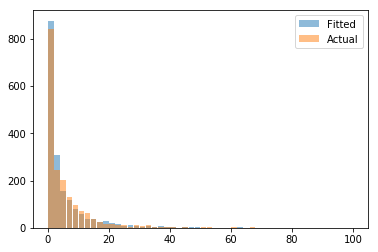

In [8]:
r = NCtrain['Wait Time (s)'].values

dst = Distribution()
dst.Fit(r)
dst.Plot(r)

In [9]:
dst.dist_results

[('weibull_min', 5.3153777664423024e-15)]

In [10]:
dst.params

{'weibull_min': (0.61, 0, 3.668768247321892)}

In [ ]:
##randgamma=gamma.rvs(0.4,0,18 ,size=len(NCtrain['Wait Time (s)'].values))

In [ ]:
#randweib=weibull_min.rvs(.61,0,3.75 ,size=len(NCtrain['Wait Time (s)'].values))

#plt.plot(gamma.pdf(discreteTimes,0.3,0,1.5),discreteTimes)
#plt.hist(r,bins=50,alpha=0.5, label='actual')
#plt.hist(randgamma,bins=50,alpha=0.5, label='random')
#plt.legend(loc='upper right')

### Weibulll

In [11]:
k = dst.params['weibull_min'][0]
lamb = dst.params['weibull_min'][2]

In [12]:
def Base(t):
    if t==0.0:
        t=0.1
    base = (k/lamb) * ((t/lamb)**(k-1))
    return base

def CumBase(t):
    CumBase=(t/lamb)**k
    return CumBase

def Surv(t):
    s = (np.exp(-(t/lamb)**k))**parthazard
    return s

In [16]:
predictedwait.shape

(1832, 1)

In [13]:
predictedwait = pd.DataFrame(columns=['Wait Time (s)'])
medwait = pd.DataFrame(columns=['Wait Time (s)'])

for n in range(xtrain.shape[0]):
    parthazard = parthazards[n][0]
    med = statistics.median(np.exp(-CumBase(discreteTimes)*parthazard))
    expected = integrate.quad(Surv, 0, 100)[0]
    predictedwait =  predictedwait.append({'Wait Time (s)': expected}, ignore_index=True)
    medwait =  medwait.append({'Wait Time (s)': med}, ignore_index=True)

In [ ]:
plt.hist(predictedwait.values, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Predicted')
plt.hist(NCtrain['Wait Time (s)'], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
plt.hist(medwait, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Median')
plt.legend(loc='upper right')

In [17]:
RMSE = np.sqrt(np.mean((predictedwait-pd.DataFrame(NCtrain['Wait Time (s)']))**2))

RMSEm = np.sqrt(np.mean((medwait-pd.DataFrame(NCtrain['Wait Time (s)']))**2))

print (RMSE,RMSEm)

### Matlab method weibull

In [ ]:
def mean_crude(t):
    p = t * Base(t) * parthazard * Surv(t)
    return p

#Train set prediction and validation
predictedwait = pd.DataFrame(columns=['Wait Time (s)'])

for n in range(xtrain.shape[0]):
    parthazard = parthazards[n]
    expected = integrate.quad(mean_crude, 0, 100)[0]
    predictedwait =  predictedwait.append({'Wait Time (s)': expected}, ignore_index=True)

predictedwait.index=pd.DataFrame(NCtrain['Wait Time (s)']).index

In [ ]:
plt.hist(predictedwait.values, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Predicted')
plt.hist(NCtrain['Wait Time (s)'], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
plt.legend(loc='upper right')

In [ ]:
RMSE = np.sqrt(np.mean((predictedwait-pd.DataFrame(NCtrain['Wait Time (s)']))**2))

print (RMSE)

In [ ]:
AVG = pd.DataFrame(predictedwait['Wait Time (s)']).mean()
print (AVG)

### Custom CDF

In [ ]:
eventtimes = NCtrain.sort_values(by=['Wait Time (s)'])['Wait Time (s)'].unique()   
eventnum = NCtrain['Wait Time (s)'].value_counts().sort_index() 

def customCDF(t):
    #loc = np.where(eventtimes >= t)[0][0]
    cum = np.cumsum(eventnum)
    CDFs = cum/sum(eventnum)
    cdf = np.interp(t, eventtimes, CDFs)
    return cdf

def Surv(t):
    s = (1-customCDF(t))**parthazard
    return s

In [ ]:
predictedwait = pd.DataFrame(columns=['Wait Time (s)'])
for n in range(xtrain.shape[0]):
    parthazard = parthazards[n][0]
    expected = integrate.quad(Surv, 0, 100)[0]
    predictedwait =  predictedwait.append({'Wait Time (s)': expected}, ignore_index=True)
    
predictedwait.index=pd.DataFrame(NCtrain['Wait Time (s)']).index

In [ ]:
plt.hist(predictedwait.values, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Predicted')
plt.hist(NCtrain['Wait Time (s)'], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
plt.legend(loc='upper right')

In [ ]:
RMSE = np.sqrt(np.mean((predictedwait-pd.DataFrame(NCtrain['Wait Time (s)']))**2))

print (RMSE)

In [ ]:
AVG = pd.DataFrame(predictedwait['Wait Time (s)']).mean()
print (AVG)

### Finding Opt Weibull params

In [25]:
def parameterOpt(x):
    k = x[0]
    lamb = x[1]
    predictedwait = []
    medwait = []
    for n in range(xtrain.shape[0]):
        parthazard = parthazards[n][0]
        #Surv = lambda t: (np.exp(-(t/lamb)**k))**parthazard
        CumBase = lambda t : (t/lamb)**k
        med = statistics.median(np.exp(-CumBase(discreteTimes)*parthazard))
        #expected = integrate.quad(Surv, 0, 100)[0]
        #predictedwait.append(expected)
        medwait.append(med)
    #predictedwait = np.array(predictedwait)
    medwait = np.array(medwait)
    #err = np.sqrt(np.mean((predictedwait-ytrain[:,1])**2))
    err = np.sqrt(np.mean((medwait-ytrain[:,1])**2))
    return err

In [26]:
from scipy.optimize import minimize
bnds = ((0, None), (0, None))

In [27]:
res = minimize(parameterOpt, (1,1), method='SLSQP', bounds=bnds)

In [28]:
res

     fun: 10.691613046641715
     jac: array([0.46015489, 0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 16
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([1.22124533e-15, 1.25769902e+00])

In [29]:
plt.hist(parameterOpt((1.109, 4.32))[1], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Predicted')
plt.hist(ytrain[:,1], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
plt.legend(loc='upper right')

IndexError: invalid index to scalar variable.

### optimal lambda matlab method

In [ ]:
def parameterOpt(x):
    k = x[0]
    lamb = x[1]
    predictedwait = []
    for n in range(xtrain.shape[0]):
        parthazard = parthazards[n][0]
        Base= lambda t: (k/lamb) * ((t/lamb)**(k-1)) #if t>0 else 
        Surv = lambda t: (np.exp(-(t/lamb)**k))**parthazard
        mean_crude = lambda t: t * Base(t) * parthazard * Surv(t)
        expected = integrate.quad(mean_crude, 0, 100)[0]
        predictedwait.append(expected)
    predictedwait = np.array(predictedwait)
    err = np.sqrt(np.mean((predictedwait-ytrain[:,1])**2))
    return err,predictedwait

In [ ]:
from scipy.optimize import minimize
bnds = ((0, None), (0, None))

In [ ]:
res = minimize(parameterOpt, (10,10), method='SLSQP', bounds=bnds)

In [ ]:
res

In [ ]:
parameterOpt((1.3766519, 5.4949331))

In [ ]:
plt.hist(parameterOpt((1.3766519, 5.4949331))[1], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Predicted')
plt.hist(ytrain[:,1], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
plt.legend(loc='upper right')

### optimal Gamma method

### Weibull Smoothe method 1.

In [ ]:
def logcumbase(t):
    zed0 = k* np.log(t) - k* np.log(lamb)
    return zed0

In [ ]:
CumBase = np.exp(np.vectorize(logcumbase)(discreteTimes))

In [ ]:
predictedwait = pd.DataFrame(columns=['Wait Time (s)'])
for n in range(xtrain.shape[0]):
    hazardarray = cumhazard(xtrain[n:n+1,0:network.hyperparams['n_in']])
    surv = np.exp(-hazardarray)
    expected = np.trapz(surv,discreteTimes)
    predictedwait =  predictedwait.append({'Wait Time (s)': expected}, ignore_index=True)

In [ ]:
predictedwait.index=pd.DataFrame(NCtrain['Wait Time (s)']).index

In [ ]:
plt.hist(predictedwait.values, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Predicted')
plt.hist(NCtrain['Wait Time (s)'], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
plt.legend(loc='upper right')

In [ ]:
RMSE = np.sqrt(np.mean((predictedwait-pd.DataFrame(NCtrain['Wait Time (s)']))**2))

print (RMSE)
